In [1]:
import pandas as pd
import scipy as sc
import numpy as np
import time
import sys
from sklearn.preprocessing import MultiLabelBinarizer

In [2]:
# addresses of the files
train_file = '../data/train.csv'
target_playlists_file = '../data/target_playlists.csv'
tracks_file = '../data/tracks.csv'

# reading of all files and renaming columns
train_data = pd.read_csv(train_file)
train_data.columns = ['playlist_id', 'track_id']

tracks_data = pd.read_csv(tracks_file)
tracks_data.columns = ['track_id', 'album_id', 'artist_id', 'duration_sec']

target_playlists = pd.read_csv(target_playlists_file)
target_playlists.columns = ['playlist_id']

In [3]:
# building the URM matrix
grouped_playlists = train_data.groupby('playlist_id', as_index=True).apply(lambda x: list(x['track_id']))
URM = MultiLabelBinarizer(sparse_output=True).fit_transform(grouped_playlists)
URM_csr = URM.tocsr()

In [4]:
# building the ICM matrix
artists = tracks_data.reindex(columns=['track_id', 'artist_id'])
artists.sort_values(by='track_id', inplace=True) # this seems not useful, values are already ordered
artists_list = [[a] for a in artists['artist_id']]
icm_artists = MultiLabelBinarizer(sparse_output=True).fit_transform(artists_list)
icm_artists_csr = icm_artists.tocsr()

albums = tracks_data.reindex(columns=['track_id', 'album_id'])
albums.sort_values(by='track_id', inplace=True) # this seems not useful, values are already ordered
albums_list = [[a] for a in albums['album_id']]
icm_albums = MultiLabelBinarizer(sparse_output=True).fit_transform(albums_list)
icm_albums_csr = icm_albums.tocsr()

durations = tracks_data.reindex(columns=['track_id', 'duration_sec'])
durations.sort_values(by='track_id', inplace=True) # this seems not useful, values are already ordered
durations_list = [[d] for d in durations['duration_sec']]
icm_durations = MultiLabelBinarizer(sparse_output=True).fit_transform(durations_list)
icm_durations_csr = icm_durations.tocsr()

ICM = sc.sparse.hstack((icm_albums_csr, icm_artists_csr, icm_durations_csr))
ICM_csr = ICM.tocsr()

In [42]:
def initialize_output_file():
    file = open("submission.csv", 'a')
    file.write("playlist_id,track_ids" + '\n')
    return file

# useful to print to file with the right structure
def print_to_file(playlist, tracks, file):
    file.write(str(playlist) + ',')
    index = 0
    while index < 9:
        file.write(str(tracks[index]) + ' ')
        index += 1
    file.write(str(tracks[index]) + '\n')

In [4]:
class ItemCBFKNNRecommender(object):
    
    def __init__(self, URM):
        self.URM = URM
        
            
    def fit(self, topK=50, shrink=100, normalize = True, similarity = "cosine"):
        
        similarity_object = Compute_Similarity_Python(self.URM, shrink=shrink, 
                                                  topK=topK, normalize=normalize, 
                                                  similarity = similarity)
        
        self.W_sparse = similarity_object.compute_similarity()

        
    def recommend(self, user_id, at=None, exclude_seen=True):
        # compute the scores using the dot product
        user_profile = self.URM[user_id]
        scores = user_profile.dot(self.W_sparse).toarray().ravel()

        if exclude_seen:
            scores = self.filter_seen(user_id, scores)

        # rank items
        ranking = scores.argsort()[::-1]
            
        return ranking[:at]
    
    
    def filter_seen(self, user_id, scores):

        start_pos = self.URM.indptr[user_id]
        end_pos = self.URM.indptr[user_id+1]

        user_profile = self.URM.indices[start_pos:end_pos]
        
        scores[user_profile] = -np.inf

        return scores

In [5]:
from data_splitter import train_test_holdout


URM_train, URM_test = train_test_holdout(URM_csr, train_perc = 0.8)


from evaluation_function import evaluate_algorithm
from Compute_Similarity_Python import Compute_Similarity_Python


In [6]:
np.shape(URM_csr)

(50446, 20635)

In [7]:
np.shape(URM_train)

(50446, 20635)

In [8]:
np.shape(URM_test)

(50446, 20635)

In [9]:
recommender = ItemCBFKNNRecommender(URM_train)
recommender.fit(shrink=5, topK=100)

Similarity column 14700 ( 71 % ), 487.47 column/sec, elapsed time 0.50 min
Similarity column 20600 ( 100 % ), 524.56 column/sec, elapsed time 0.65 min


In [10]:
evaluate_algorithm(URM_test, recommender)

Evaluated user 0 of 50446
Evaluated user 10000 of 50446
Evaluated user 20000 of 50446
Evaluated user 30000 of 50446
Evaluated user 40000 of 50446
Evaluated user 50000 of 50446
Recommender performance is: Precision = 0.1617, Recall = 0.1460, MAP = 0.1160


{'precision': 0.16172729079707832,
 'recall': 0.1459646557968756,
 'MAP': 0.11604565245803936}

In [11]:
recommender = ItemCBFKNNRecommender(URM_train)
recommender.fit(shrink=5, topK=100, normalize=False)

Similarity column 20600 ( 100 % ), 809.38 column/sec, elapsed time 0.42 min


In [12]:
evaluate_algorithm(URM_test, recommender)

Evaluated user 0 of 50446
Evaluated user 10000 of 50446
Evaluated user 20000 of 50446
Evaluated user 30000 of 50446
Evaluated user 40000 of 50446
Evaluated user 50000 of 50446
Recommender performance is: Precision = 0.1405, Recall = 0.1277, MAP = 0.0970


{'precision': 0.14052474657127562,
 'recall': 0.12768927953597986,
 'MAP': 0.09704974020608854}

In [34]:
x_tick = [150, 250]
MAP_per_k = []

for topK in x_tick:
    
    recommender.fit(shrink=0.0, topK=topK)
    
    result_dict = evaluate_algorithm(URM_test, recommender)
    MAP_per_k.append(result_dict["MAP"])

Similarity column 20600 ( 100 % ), 2277.69 column/sec, elapsed time 0.15 min
Evaluated user 0 of 50446
Evaluated user 10000 of 50446
Evaluated user 20000 of 50446
Evaluated user 30000 of 50446
Evaluated user 40000 of 50446
Evaluated user 50000 of 50446
Recommender performance is: Precision = 0.0919, Recall = 0.0488, MAP = 0.0666
Similarity column 20600 ( 100 % ), 2167.51 column/sec, elapsed time 0.16 min
Evaluated user 0 of 50446
Evaluated user 10000 of 50446
Evaluated user 20000 of 50446
Evaluated user 30000 of 50446
Evaluated user 40000 of 50446
Evaluated user 50000 of 50446
Recommender performance is: Precision = 0.0920, Recall = 0.0491, MAP = 0.0668


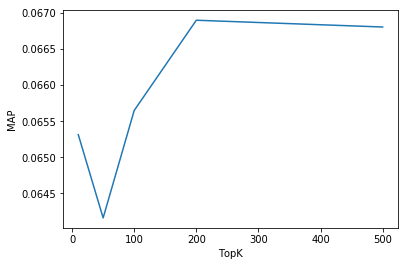

In [33]:
import matplotlib.pyplot as pyplot

pyplot.plot(x_tick, MAP_per_k)
pyplot.ylabel('MAP')
pyplot.xlabel('TopK')
pyplot.show()

In [44]:
# execution of the recommendations
file = initialize_output_file()

for playlist in target_playlists.itertuples(index=True, name='Pandas'):
    playlist_id = getattr(playlist, "playlist_id")
    tracks = recommender.recommend(playlist_id, 10, True)
    print_to_file(playlist_id, tracks, file)
    
file.close()